## LSTM

Source: [https://cnvrg.io/pytorch-lstm/]

Basically a NN for sequential data.

You'll see below that for the testing data, the predicted stock prices aren't super accurate but the model identifies the trend of the stock pretty well.

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.autograd import Variable 
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

In [11]:
%load_ext autoreload
%autoreload 2
from lstm_model import LSTMModel

### Create Data

In [156]:
ticker = 'XOM'
start_date = '2014-01-01'
end_date = '2024-01-01'

# data = yf.download(ticker, start=start_date, end=end_date)
ticker_data = yf.Ticker(ticker)
data = ticker_data.history(start=start_date, end=end_date)

# Calculate the daily returns
data['Returns'] = data['Close'].pct_change()

# Calculate moving averages and std
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['Std_Dev'] = data['Close'].rolling(window=20).std()

# Calculate the z-score
data['Z_Score'] = (data['Close'] - data['SMA_20']) / data['Std_Dev']

# Calculate RSI
delta = data['Close'].diff()
up = delta.clip(lower=0)
down = -1 * delta.clip(upper=0)
ema_up = up.ewm(com=13, adjust=False).mean()
ema_down = down.ewm(com=13, adjust=False).mean()
rs = ema_up / ema_down

data['RSI'] = 100 - (100 / (1 + rs))

# Calculate TTM EPS and P/E
eps = ticker_data.get_earnings_dates(limit=60)
eps = eps[(eps.index >= (data.index[0]-relativedelta(years=1))) & (eps.index <= data.index[-1])]
eps = eps.iloc[::-1]
eps['TTM'] = eps['Reported EPS'].rolling(window=4).sum()
eps.index = eps.index.date
idx = pd.date_range(eps.index[0], eps.index[-1])
eps = eps.reindex(idx.date, fill_value=np.nan)
data.index = data.index.date
data['TTM_EPS'] = eps['TTM'].copy()
data[data['TTM_EPS'].notna()]
data['TTM_EPS'] = data['TTM_EPS'].ffill()
data['TTM_EPS'] = data['TTM_EPS'].fillna(eps['TTM'].loc[eps['TTM'].notna()].iloc[0])
data['TTM_P/E'] = data['Close'] / data['TTM_EPS']

# If stock price goes up or down
data['Target'] = data['Close'].shift(-1)

data.dropna(inplace=True)

# Wanted features for X and y
features = ['Close', 'Returns', 'SMA_20', 'SMA_50', 'Std_Dev', 'Z_Score', 'RSI', 'TTM_EPS', 'TTM_P/E']
X = data.loc[:, data.columns != 'Target']
y = data.iloc[:, (data.shape[1]-1):(data.shape[1])]

In [35]:
X

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Returns,SMA_20,SMA_50,Std_Dev,Z_Score,RSI,TTM_EPS,TTM_P/E
2014-03-14,60.733145,61.148502,60.544935,60.661755,11723300,0.0,0.0,-0.001815,61.608635,61.664022,0.684112,-1.384101,44.303430,7.37,8.230903
2014-03-17,60.973279,61.349698,60.843481,61.213409,8676100,0.0,0.0,0.009094,61.615450,61.602647,0.679200,-0.591932,48.781005,7.37,8.305754
2014-03-18,61.271799,61.816954,61.051138,61.466496,8757300,0.0,0.0,0.004134,61.636217,61.549427,0.667283,-0.254347,50.737664,7.37,8.340094
2014-03-19,61.427566,61.849415,60.441088,60.830490,9914700,0.0,0.0,-0.010347,61.629078,61.481553,0.675463,-1.182283,45.983609,7.37,8.253798
2014-03-20,60.642274,61.485967,60.363205,61.382130,10405000,0.0,0.0,0.009068,61.603443,61.406539,0.674574,-0.328078,50.330721,7.37,8.328647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,100.535658,101.070687,99.881732,100.793266,19250900,0.0,0.0,0.004542,100.424687,103.165610,1.916560,0.192313,48.493679,10.44,9.654527
2023-12-22,101.367922,101.992126,100.882436,100.971611,12921800,0.0,0.0,0.001769,100.292912,103.094368,1.771334,0.383157,49.168148,10.44,9.671610
2023-12-26,101.793959,102.081290,101.179673,101.199486,16835100,0.0,0.0,0.002257,100.202750,102.960920,1.669085,0.597175,50.067858,10.44,9.693437
2023-12-27,101.100406,101.605712,100.406847,100.723907,14558800,0.0,0.0,-0.004699,100.091782,102.816389,1.546573,0.408727,48.152305,10.44,9.647884


### Scale Data

In [36]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

mm = MinMaxScaler()
ss = StandardScaler()
# mm2 = MinMaxScaler()
# ss2 = StandardScaler()

# X_ss = pd.DataFrame(ss.fit_transform(X), index=X.index, columns=X.columns)
# y_mm = pd.DataFrame(mm.fit_transform(y), index=y.index, columns=y.columns)

# Split data into first 80% and last 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)
X_train_ss = pd.DataFrame(ss.fit_transform(X_train), index=X_train.index, columns=X.columns) # fit ss and transform X_train
y_train_mm = pd.DataFrame(mm.fit_transform(y_train), index=y_train.index, columns=y.columns) # fit mm and transform y_train
X_test_ss = pd.DataFrame(ss.transform(X_test), index=X_test.index, columns=X.columns) # transform X_test with fitted ss
y_test_mm = pd.DataFrame(mm.transform(y_test), index=y_test.index, columns=y.columns) # transform y_test with fitted mm

## Prepare Data for LSTM

Converts the Numpy Arrays to Tensors and to Variables (which can be differentiated).

In [37]:
features_ = ['SMA_20', 'SMA_50', 'Std_Dev', 'Z_Score', 'RSI', 'Close', 'TTM_P/E'] # Features to train with.
X_train_tensors = Variable(torch.Tensor(np.array(X_train_ss[features_])))
X_test_tensors = Variable(torch.Tensor(np.array(X_test_ss[features_])))

y_train_tensors = Variable(torch.Tensor(y_train_mm.values))
y_test_tensors = Variable(torch.Tensor(y_test_mm.values))

In [38]:
X_train_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

In [39]:
print("Training Shape", X_train_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([2219, 1, 7]) torch.Size([2219, 1])
Testing Shape torch.Size([247, 1, 7]) torch.Size([247, 1])


### Training

In [48]:
num_epochs = 1000 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = X_train_final.shape[2] # number of features
hidden_size = 32 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers
batch_size = X_train_tensors.shape[0]
window = 1

num_classes = 1 #number of output classes

In [49]:
lstm = LSTMModel(num_classes, input_size, hidden_size, num_layers, seq_length=window, batch_size=batch_size) #our lstm class 

In [50]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate) # ADAM optimizer

In [51]:
# from custom_data_loader import MyDataset

In [52]:
# data_loader_train = torch.utils.data.DataLoader(
#     MyDataset((X_train_tensors, y_train_tensors), window),
#     batch_size=batch_size,
#     shuffle=False
# )

In [53]:
data_loader_train = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train_final, y_train_tensors),
    batch_size=batch_size,
    shuffle=False
)

In [54]:
for i, (X_, y_) in enumerate(data_loader_train):
    if i == 0:
        print(X_.size())
        print(y_.size())

torch.Size([2219, 1, 7])
torch.Size([2219, 1])


In [55]:
for epoch in range(num_epochs):
  for i, data in enumerate(data_loader_train):
    X_, y_ = data
    outputs = lstm.forward(X_) #forward pass
    optimizer.zero_grad() #calculate the gradient, manually setting to 0
  
    # obtain the loss function
    loss = criterion(outputs, y_.reshape(y_.size(0)*y_.size(1), 1))
  
    loss.backward() #calculates the loss of the loss function
  
    optimizer.step() #improve from loss, i.e backprop
    # if (i + 1) % 50 == 0:
    #     print(f"Epoch {epoch}, batch {i:>3}, loss on batch: {loss.item():.3f}")
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.12439
Epoch: 100, loss: 0.00025
Epoch: 200, loss: 0.00017
Epoch: 300, loss: 0.00016
Epoch: 400, loss: 0.00015
Epoch: 500, loss: 0.00014
Epoch: 600, loss: 0.00014
Epoch: 700, loss: 0.00014
Epoch: 800, loss: 0.00014
Epoch: 900, loss: 0.00013


In [56]:
for i, (X_, y_) in enumerate(data_loader_train):
    if i == 0:
        train_predict = lstm(X_).data.numpy()
    else:
        train_predict = np.append(train_predict, lstm(X_).data.numpy(), axis=0)

In [57]:
# run these once
train_predict = mm.inverse_transform(train_predict) # reverse transformation
X_train = pd.DataFrame(ss.inverse_transform(X_train_ss), index=X_train_ss.index, columns=X_train_ss.columns) # reverse transformation for training data

In [58]:
predicted_price = pd.DataFrame(train_predict)
predicted_price.columns = ['Predicted_Price']
predicted_price.size
idx = X_train.index[:predicted_price.size]
predicted_price.index = idx
X_train = pd.concat([X_train, predicted_price], ignore_index=False, axis=1)
X_train = X_train.dropna()

Accuracy: 0.9743127534925642


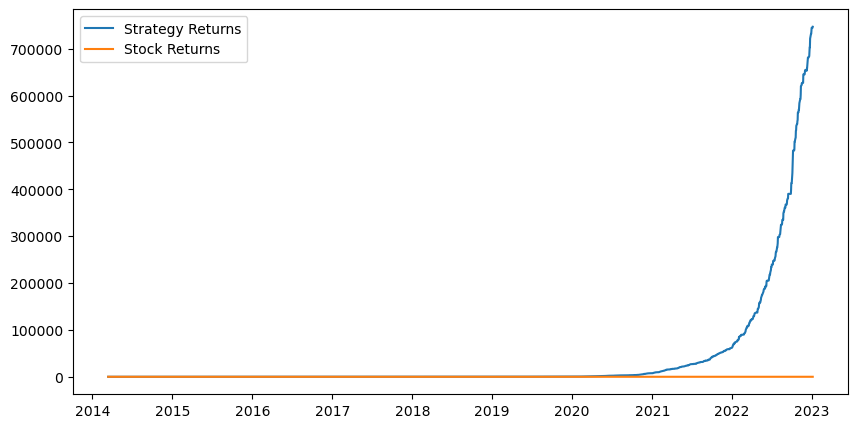

In [59]:
#X_train['Predicted_Price'] = data_predict
X_train['Actual_Signal'] = (X_train['Returns'].shift(-1) > 0).astype(int) # actual signal, 1 if next-day returns > 0, 0 if next-day returns <= 0
X_train['Predicted_Returns'] = X_train['Predicted_Price'].pct_change() # calculate returns of predicted stock price
X_train['Predicted_Signal'] = (X_train['Predicted_Returns'].shift(-1) > 0).astype(int) # predicted signal based on predicted returns
X_train['Strategy_Returns'] = X_train['Returns'] * X_train['Predicted_Signal'].shift(1) # strategy returns
cumulative_strategy_returns = (X_train['Strategy_Returns'].fillna(0) + 1).cumprod()
returns = X_train.loc[X_train.index, 'Returns']
returns.iloc[0] = 0 # set the first actual return to 0 to ensure that both plots start at 1.
cumulative_stock_returns = (returns + 1).cumprod() # returns of the stock (basically if we held the stock for the entire duration)
accuracy = (X_train['Actual_Signal'] == X_train['Predicted_Signal']).mean() # accuracy of predicted signal
print(f'Accuracy: {accuracy}')

plt.figure(figsize=(10,5))
plt.plot(cumulative_strategy_returns, label='Strategy Returns')
plt.plot(cumulative_stock_returns, label='Stock Returns')
plt.legend();

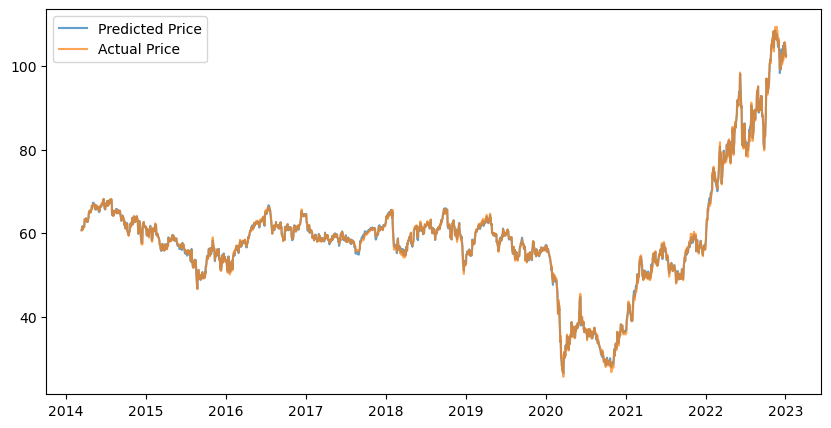

In [60]:
plt.figure(figsize=(10,5))
plt.plot(X_train['Predicted_Price'], label='Predicted Price', alpha=0.7)
plt.plot(X_train['Close'], label='Actual Price', alpha=0.7)
plt.legend();

In [61]:
test_predict = lstm(X_test_final).data.numpy()

In [62]:
test_predict = mm.inverse_transform(test_predict)
X_test = pd.DataFrame(ss.inverse_transform(X_test_ss), index=X_test_ss.index, columns=X_test_ss.columns)

In [63]:
predicted_price = pd.DataFrame(test_predict)
predicted_price.columns = ['Predicted_Price']
predicted_price.size
idx = X_test.index[:predicted_price.size]
predicted_price.index = idx
X_test = pd.concat([X_test, predicted_price], ignore_index=False, axis=1)
X_test = X_test.dropna()

Accuracy: 0.9190283400809717


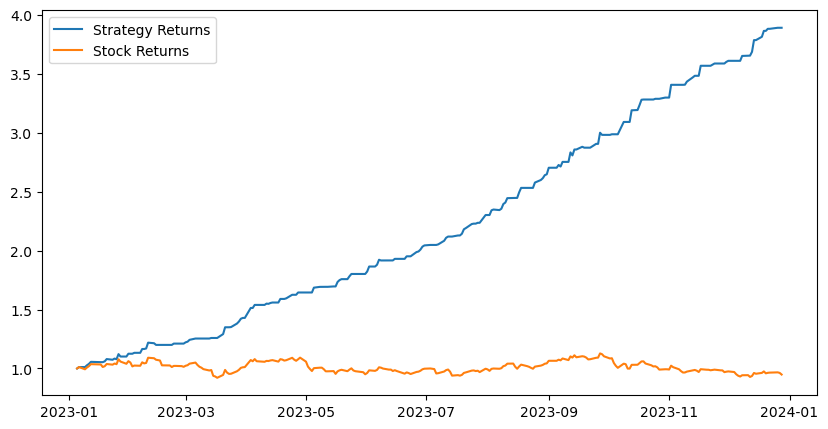

In [64]:
X_test['Actual_Signal'] = (X_test['Returns'].shift(-1) > 0).astype(int)
#X_test['Predicted_Price'] = data_predict
X_test['Predicted_Returns'] = X_test['Predicted_Price'].pct_change()
X_test['Predicted_Signal'] = (X_test['Predicted_Returns'].shift(-1) > 0).astype(int)
X_test['Strategy_Returns'] = X_test['Returns'] * X_test['Predicted_Signal'].shift(1)
cumulative_strategy_returns = (X_test['Strategy_Returns'].fillna(0) + 1).cumprod()
returns = X_test.loc[X_test.index, 'Returns']
returns.iloc[0] = 0
cumulative_stock_returns = (returns + 1).cumprod()
accuracy = (X_test['Actual_Signal'] == X_test['Predicted_Signal']).mean()
print(f'Accuracy: {accuracy}')
# Calculate cumulative returns for the market
#market_data['Returns'] = market_data['Close'].pct_change()
#cumulative_market_returns = (market_data['Returns'].fillna(0) + 1).cumprod()

plt.figure(figsize=(10,5))

plt.plot(cumulative_strategy_returns, label='Strategy Returns')
#plt.plot(cumulative_market_returns, label='Market Returns')
plt.plot(cumulative_stock_returns, label='Stock Returns')
plt.legend();

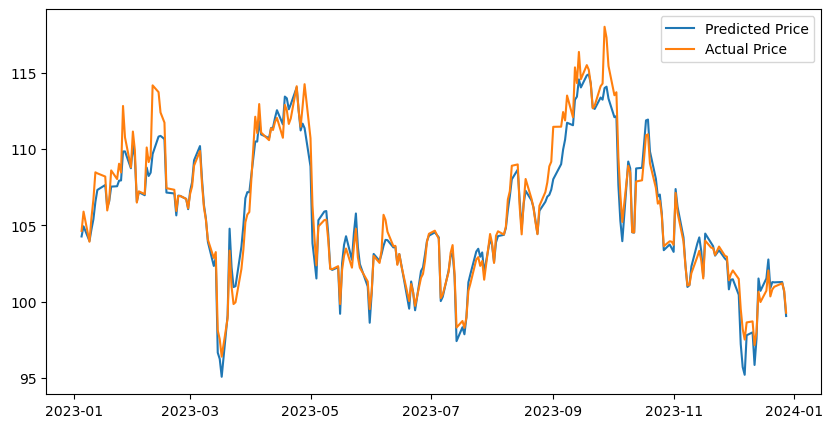

In [65]:
plt.figure(figsize=(10,5))
plt.plot(X_test['Predicted_Price'], label='Predicted Price')
plt.plot(X_test['Close'], label='Actual Price')
plt.legend();

In [22]:
from torchinfo import summary

In [180]:
summary(lstm)

Layer (type:depth-idx)                   Param #
LSTMModel                                --
├─LSTM: 1-1                              5,248
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       4,224
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       129
Total params: 9,601
Trainable params: 9,601
Non-trainable params: 0

## LSTM on 10 Biggest Energy Companies

In [1]:
tickers = ['XOM', 'CVX', 'COP', 'NEE', 'SO', 'EOG', 'DUK', 'MPC', 'SLB', 'PSX']

In [2]:
from lstm_data import prepare_data

In [65]:
# preps data, see lstm_data.py, prints size of each ticker's dataset
X_train, y_train, X_test, y_test, mm_scalers, ss_scalers, batch_size = prepare_data(tickers, start_date = '2014-01-01', end_date = '2024-01-01')

(2219, 15)
(2219, 15)
(2219, 15)
(2219, 15)
(2219, 15)
(2219, 15)
(2219, 15)
(2219, 15)
(2219, 15)
(2219, 15)


In [7]:
features = ['SMA_20', 'SMA_50', 'Std_Dev', 'Z_Score', 'RSI', 'Close', 'TTM_P/E']

X_train_tensors = Variable(torch.Tensor(np.array(X_train[features])))
y_train_tensors = Variable(torch.Tensor(y_train.values))
X_train_final = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))

In [8]:
# split data by ticker
data_loader_train = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train_final, y_train_tensors),
    batch_size=batch_size,
    shuffle=False
)

In [9]:
num_epochs = 1000 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = X_train_final.shape[2] # number of features
hidden_size = 32 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers
batch_size = batch_size
window = 1 # number of windows, leave at 1, basically can ignore

num_classes = 1 # number of output classes

In [12]:
lstm = LSTMModel(num_classes, input_size, hidden_size, num_layers, seq_length=window, batch_size=batch_size) #our lstm class 
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate) # ADAM optimizer

**Below takes about 7 min to run.**

In [13]:
for epoch in range(num_epochs):
  for i, data in enumerate(data_loader_train):
    X_, y_ = data
    outputs = lstm.forward(X_) #forward pass
    optimizer.zero_grad() #calculate the gradient, manually setting to 0
  
    # obtain the loss function
    loss = criterion(outputs, y_.reshape(y_.size(0)*y_.size(1), 1))
  
    loss.backward() #calculates the loss of the loss function
  
    optimizer.step() #improve from loss, i.e backprop
    # if (i + 1) % 50 == 0:
    #     print(f"Epoch {epoch}, batch {i:>3}, loss on batch: {loss.item():.3f}")
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.13048
Epoch: 100, loss: 0.00544
Epoch: 200, loss: 0.00522
Epoch: 300, loss: 0.00508
Epoch: 400, loss: 0.00492
Epoch: 500, loss: 0.00467
Epoch: 600, loss: 0.00444
Epoch: 700, loss: 0.00426
Epoch: 800, loss: 0.00398
Epoch: 900, loss: 0.00375


In [52]:
def evaluate_lstm(model, X_test, y_test, ss, mm, features):
    ticker = X_test['Ticker'].iloc[0] # get ticker
    X_test_tensors = Variable(torch.Tensor(np.array(X_test[features]))) # prepare for lstm
    X_test_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) # prepare for lstm

    test_predict = model(X_test_final).data.numpy() # predict
    test_predict = mm.inverse_transform(test_predict) # reverse transform back to original scale
    cols = X_test.columns[X_test.columns != 'Tickers']
    X_test = pd.DataFrame(ss.inverse_transform(X_test[cols]), index=X_test.index, columns=cols) # reverse transform X_test back to og scale
    predicted_price = pd.DataFrame(test_predict)
    predicted_price.columns = ['Predicted_Price']
    predicted_price.size
    idx = X_test.index[:predicted_price.size]
    predicted_price.index = idx # fix index of predicted prices
    X_test = pd.concat([X_test, predicted_price], ignore_index=False, axis=1) 
    X_test = X_test.dropna()
    X_test['Actual_Signal'] = (X_test['Returns'].shift(-1) > 0).astype(int) # actual buy/sell signal based on daily returns
    X_test['Predicted_Returns'] = X_test['Predicted_Price'].pct_change()
    X_test['Predicted_Signal'] = (X_test['Predicted_Returns'].shift(-1) > 0).astype(int) # predicted buy/sell signal based on predicted returns
    X_test['Strategy_Returns'] = X_test['Returns'] * X_test['Predicted_Signal'].shift(1) # calculate daily strategy returns
    cumulative_strategy_returns = (X_test['Strategy_Returns'].fillna(0) + 1).cumprod()
    returns = X_test.loc[X_test.index, 'Returns']
    returns.iloc[0] = 0
    cumulative_stock_returns = (returns + 1).cumprod()
    accuracy = (X_test['Actual_Signal'] == X_test['Predicted_Signal']).mean()
    print(f'{ticker} Accuracy: {accuracy}')

    # plot returns
    plt.figure(figsize=(10,5))
    plt.plot(cumulative_strategy_returns, label='Strategy Returns')
    #plt.plot(cumulative_market_returns, label='Market Returns')
    plt.plot(cumulative_stock_returns, label='Stock Returns')
    plt.title(f'{ticker} Returns')
    plt.legend();

    # plot stock price
    plt.figure(figsize=(10,5))
    plt.plot(X_test['Predicted_Price'], label='Predicted Price')
    plt.plot(X_test['Close'], label='Actual Price')
    plt.title(f'{ticker} Price')
    plt.legend();

XOM Accuracy: 0.8421052631578947
CVX Accuracy: 0.7530364372469636
COP Accuracy: 0.7935222672064778
NEE Accuracy: 0.7408906882591093
SO Accuracy: 0.8785425101214575
EOG Accuracy: 0.8502024291497976
DUK Accuracy: 0.951417004048583
MPC Accuracy: 0.8299595141700404
SLB Accuracy: 0.805668016194332
PSX Accuracy: 0.8704453441295547


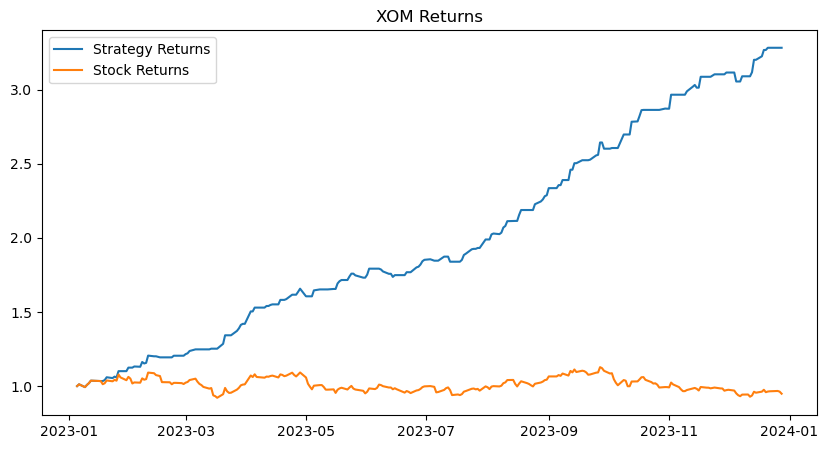

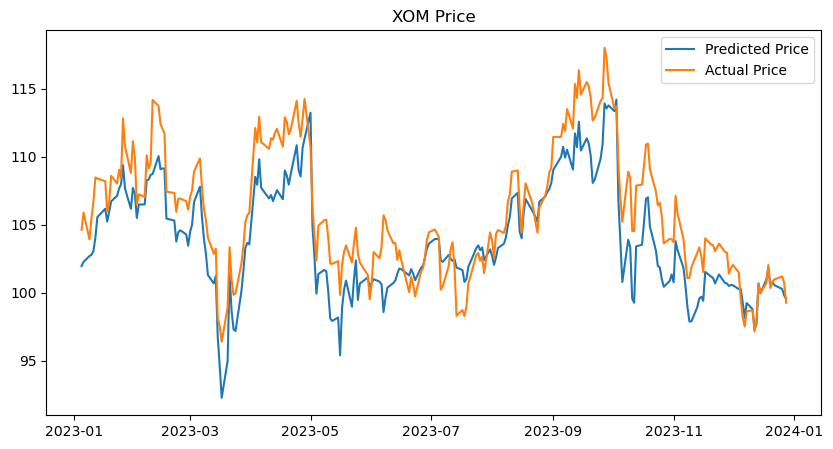

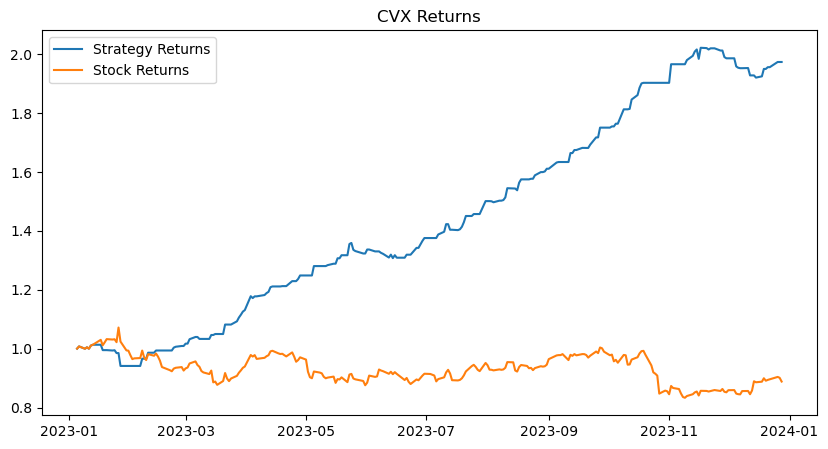

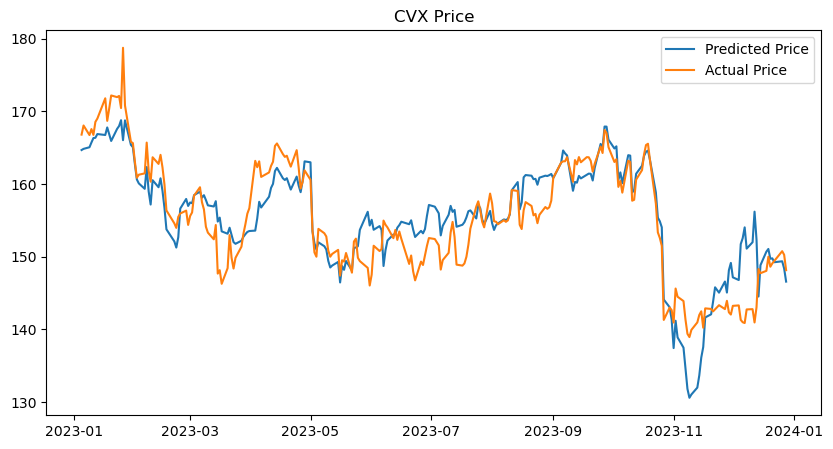

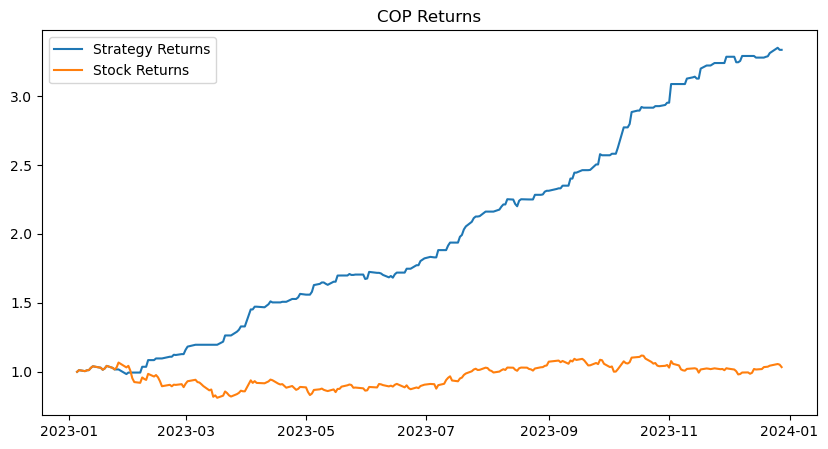

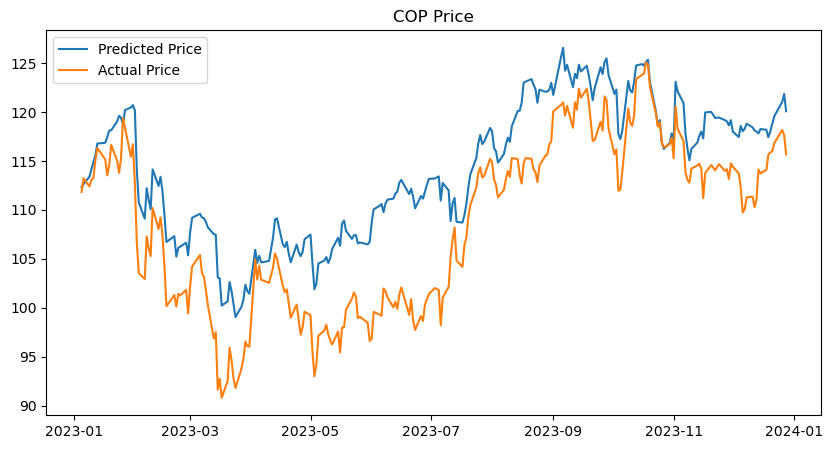

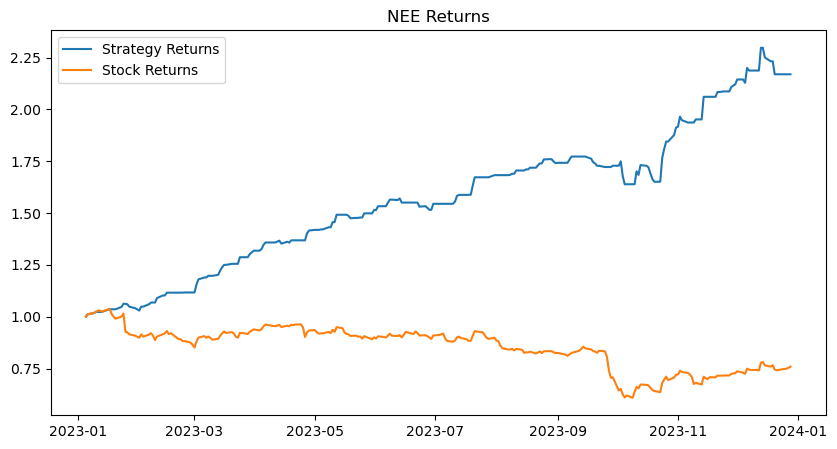

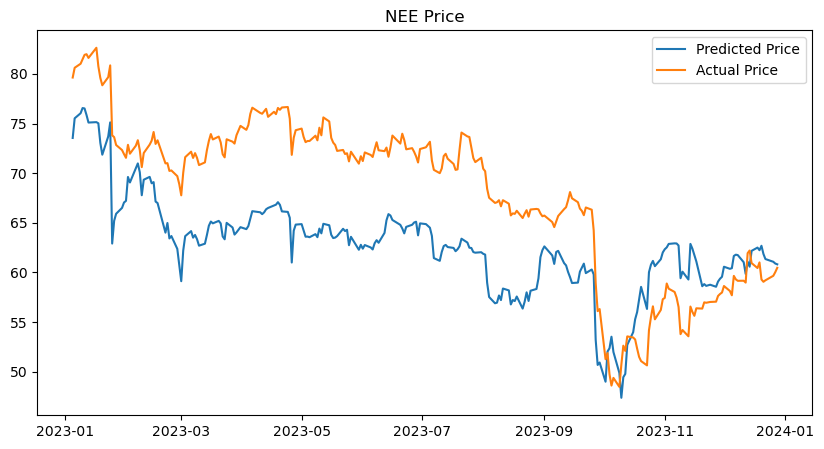

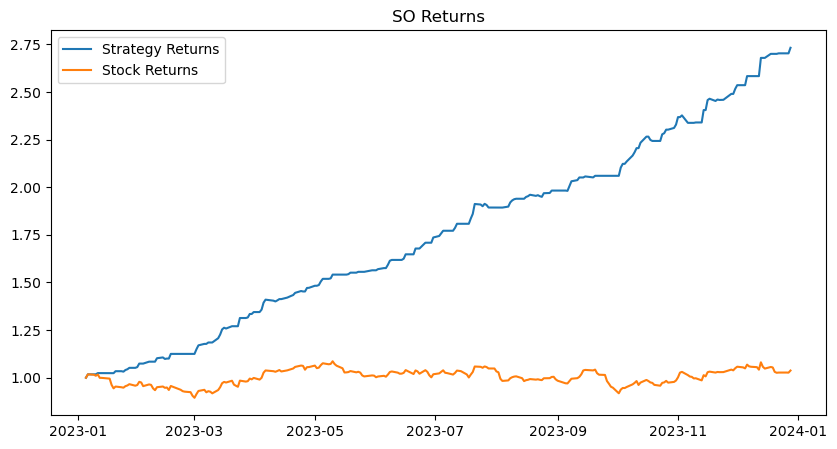

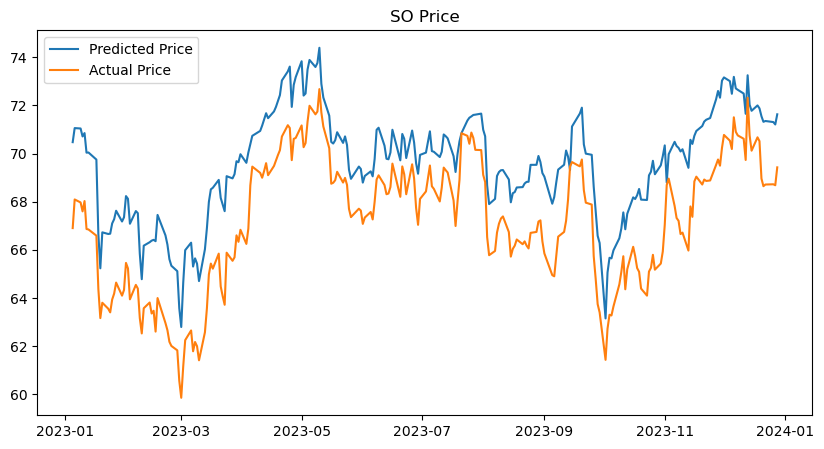

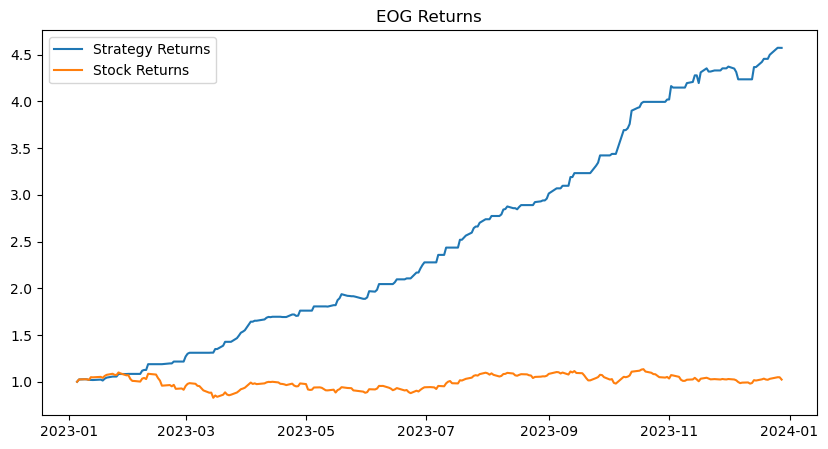

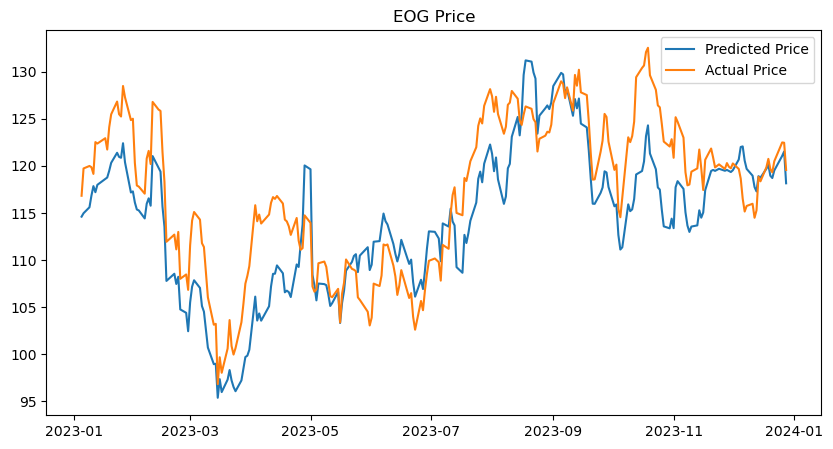

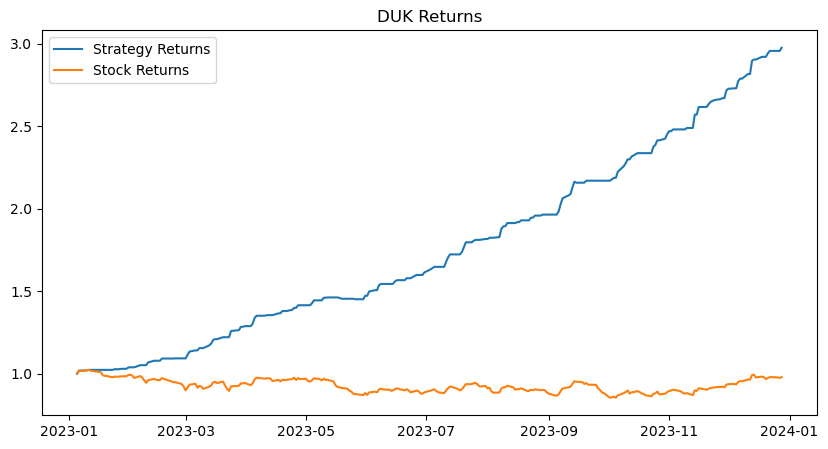

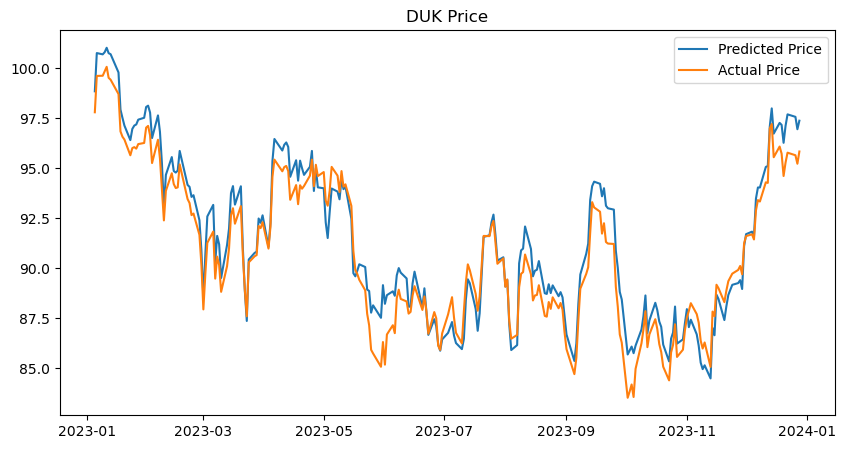

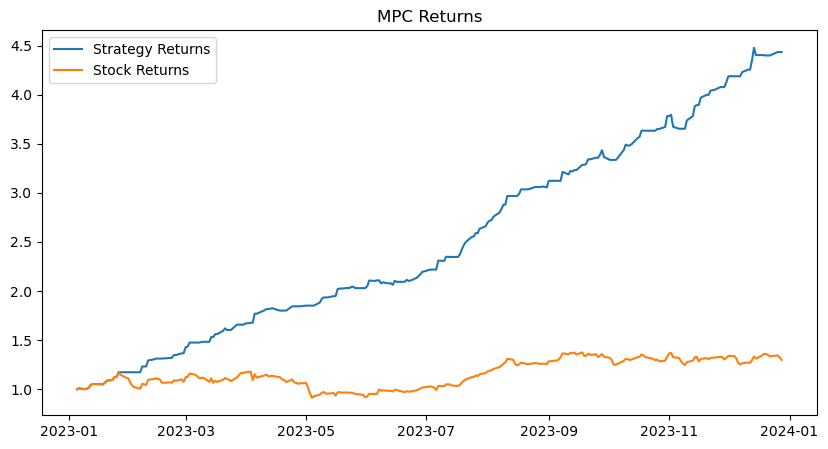

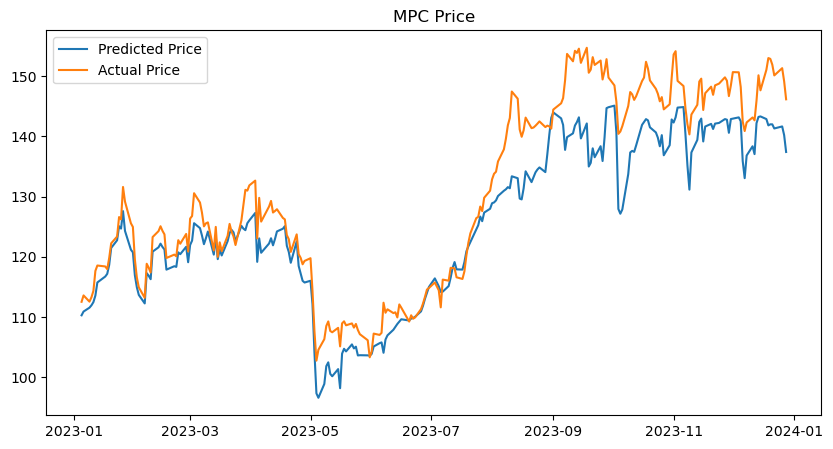

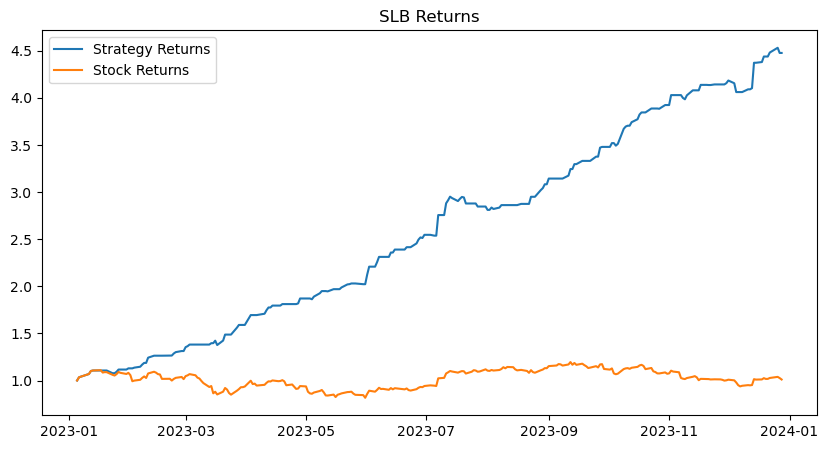

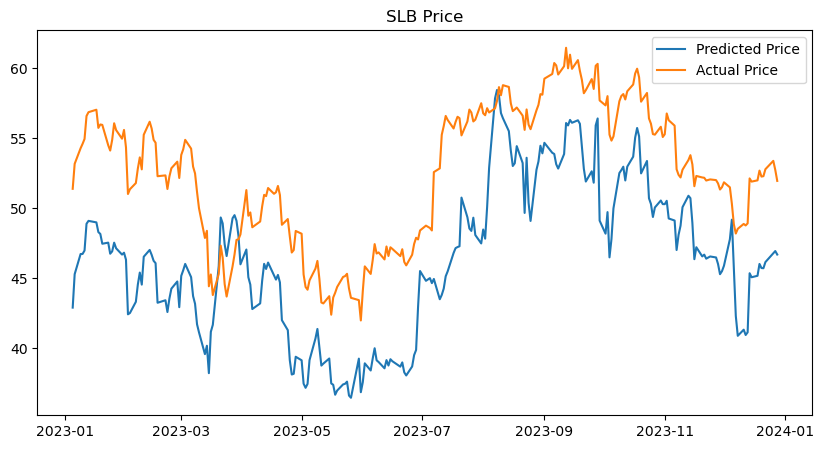

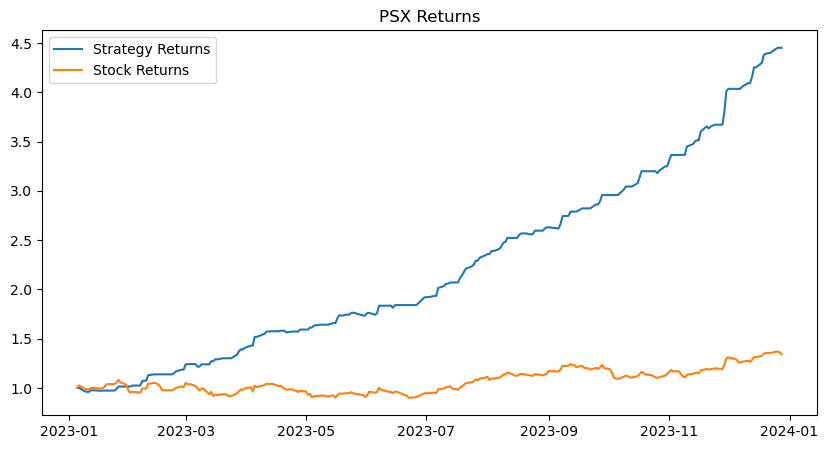

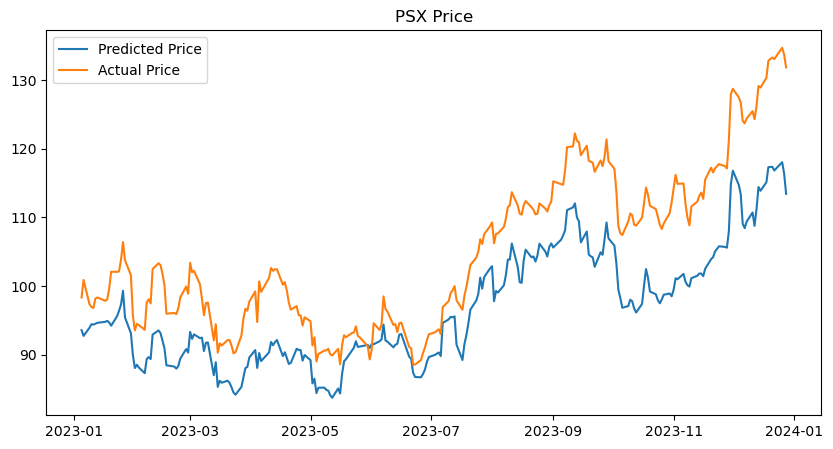

In [50]:
for i in range(10):
    evaluate_lstm(lstm, X_test[i], y_test[i], ss_scalers[i], mm_scalers[i], features)

## Further Testing

Note: need to test by combining training and test sets due to the nature of sequential data.

Accuracy: 0.8421052631578947


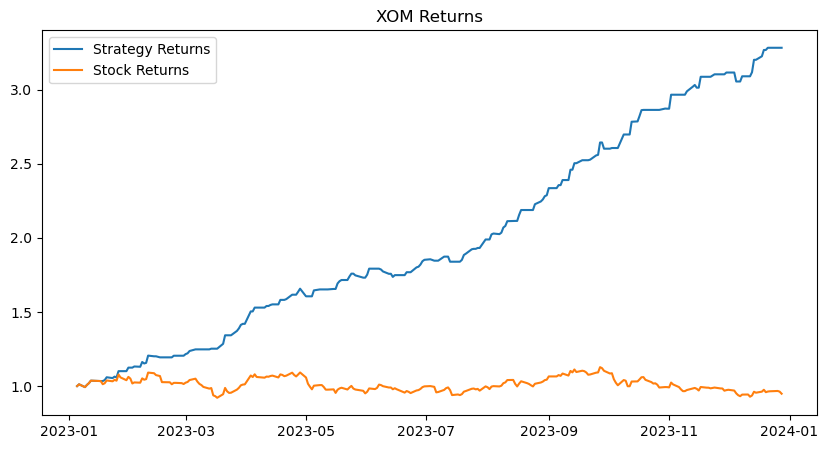

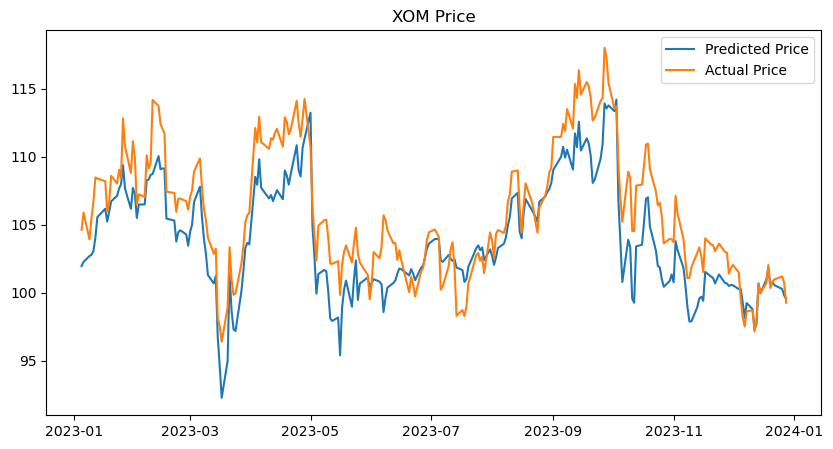

In [70]:
i = 0

ticker = X_test[i]['Ticker'].iloc[0]
X_test_tensors = Variable(torch.Tensor(np.array(X_test[i][features]))) # prepare for lstm
X_test_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) # prepare for lstm

test_predict = lstm(X_test_final).data.numpy() # predict
test_predict = mm_scalers[i].inverse_transform(test_predict) # reverse transform back to original scale
cols = X_test[i].columns[X_test[i].columns != 'Ticker']
X_test_ = pd.DataFrame(ss_scalers[i].inverse_transform(X_test[i][cols]), index=X_test[i].index, columns=cols)
predicted_price = pd.DataFrame(test_predict)
predicted_price.columns = ['Predicted_Price']
predicted_price.size
idx = X_test_.index[:predicted_price.size]
predicted_price.index = idx
X_test_ = pd.concat([X_test_, predicted_price], ignore_index=False, axis=1)
X_test_ = X_test_.dropna()
X_test_['Actual_Signal'] = (X_test_['Returns'].shift(-1) > 0).astype(int)
#X_test['Predicted_Price'] = data_predict
X_test_['Predicted_Returns'] = X_test_['Predicted_Price'].pct_change()
X_test_['Predicted_Signal'] = (X_test_['Predicted_Returns'].shift(-1) > 0).astype(int)
X_test_['Strategy_Returns'] = X_test_['Returns'] * X_test_['Predicted_Signal'].shift(1)
cumulative_strategy_returns = (X_test_['Strategy_Returns'].fillna(0) + 1).cumprod()
returns = X_test_.loc[X_test_.index, 'Returns']
returns.iloc[0] = 0
cumulative_stock_returns = (returns + 1).cumprod()
accuracy = (X_test_['Actual_Signal'] == X_test_['Predicted_Signal']).mean()
print(f'Accuracy: {accuracy}')
# Calculate cumulative returns for the market
#market_data['Returns'] = market_data['Close'].pct_change()
#cumulative_market_returns = (market_data['Returns'].fillna(0) + 1).cumprod()

plt.figure(figsize=(10,5))
plt.plot(cumulative_strategy_returns, label='Strategy Returns')
#plt.plot(cumulative_market_returns, label='Market Returns')
plt.plot(cumulative_stock_returns, label='Stock Returns')
plt.title(f'{ticker} Returns')
plt.legend();

# plot stock price
plt.figure(figsize=(10,5))
plt.plot(X_test_['Predicted_Price'], label='Predicted Price')
plt.plot(X_test_['Close'], label='Actual Price')
plt.title(f'{ticker} Price')
plt.legend();

In [48]:
summary(lstm)

Layer (type:depth-idx)                   Param #
LSTMModel                                --
├─LSTM: 1-1                              5,248
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       4,224
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       129
Total params: 9,601
Trainable params: 9,601
Non-trainable params: 0